In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
from importlib import reload
%matplotlib inline

/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-

In [2]:
sys.path.append('../odcd/cd/')

In [3]:
import model_symmetries as vsf

# Load Cifar

In [4]:
cifar = tf.keras.datasets.cifar10.load_data()

In [5]:
(x_train, y_train), (x_test, y_test) = cifar
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [8]:
print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


# Load model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

In [10]:
def model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

# Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    return model

In [11]:
model_cifar = model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model_cifar.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.7303 - acc: 0.3758 - val_loss: 1.4364 - val_acc: 0.4835
Epoch 2/10
12288/50000 [======>.......................] - ETA: 40s - loss: 1.3794 - acc: 0.5114

# Find symmetries

In [ ]:
reload(vsf)

In [228]:
vae = vsf.VaeSymmetryFinderConv(model_cifar, input_shape=x_train.shape[1:], 
                            output_shape=(10, ), intermediate_dim=128, output_activation='sigmoid')

32
Vae
Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 16, 16, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 8192)         0           conv2d_44[0][0]                  
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 16)           131088      flatten_15[0][0]                 
_____________________________________________________________________________________

In [229]:
vae.fit(x_train, x_test=x_test, epochs=50)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 67s 1ms/sample - loss: 1.3388 - val_loss: 1.0548
Epoch 2/50
50000/50000 [==============================] - 69s 1ms/sample - loss: 1.0845 - val_loss: 0.9860
Epoch 3/50
50000/50000 [==============================] - 69s 1ms/sample - loss: 1.0273 - val_loss: 0.9494
Epoch 4/50
50000/50000 [==============================] - 69s 1ms/sample - loss: 0.9760 - val_loss: 0.9010
Epoch 5/50
50000/50000 [==============================] - 69s 1ms/sample - loss: 0.9286 - val_loss: 0.9044
Epoch 6/50
50000/50000 [==============================] - 69s 1ms/sample - loss: 0.8980 - val_loss: 0.8709
Epoch 7/50
50000/50000 [==============================] - 69s 1ms/sample - loss: 0.8772 - val_loss: 0.8466
Epoch 8/50
50000/50000 [==============================] - 71s 1ms/sample - loss: 0.8515 - val_loss: 0.8226
Epoch 9/50
50000/50000 [==============================] - 71s 1ms/sample - loss: 0.8258 - val_

In [173]:
i = 42
x = x_test[i:i+1]

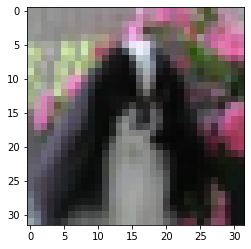

In [230]:
plt.imshow(np.squeeze(x))

In [231]:
model_cifar.predict(x)

array([[6.9339992e-05, 4.8406787e-07, 5.0648334e-03, 2.0498581e-01,
        5.1768566e-04, 6.7372775e-01, 2.1447755e-05, 1.1560838e-01,
        1.2365074e-07, 4.1257481e-06]], dtype=float32)

In [232]:
np.argmax(model_cifar.predict(x), axis=1)

array([5])

In [233]:
y_test[i:i+1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [234]:
outs_1 = vae.vae.predict(x)
outs_2 = vae.vae.predict(x)

In [235]:
symmetric_sample_1 = outs_1[0]
symmetric_sample_2 = outs_2[0]

orig_pred_1 = outs_1[1]
orig_pred_2 = outs_2[1]

trans_pred_1 = outs_1[2]
trans_pred_2 = outs_2[2]

In [236]:
orig_pred_1

array([[6.9339992e-05, 4.8406787e-07, 5.0648334e-03, 2.0498581e-01,
        5.1768566e-04, 6.7372775e-01, 2.1447755e-05, 1.1560838e-01,
        1.2365074e-07, 4.1257481e-06]], dtype=float32)

In [237]:
trans_pred_1

array([[1.2621327e-03, 6.3643020e-05, 2.7927257e-02, 3.0185729e-01,
        1.2061049e-02, 5.7909685e-01, 1.2029322e-02, 6.5047607e-02,
        2.8387140e-04, 3.7106648e-04]], dtype=float32)

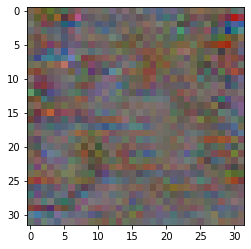

In [238]:
plt.imshow(np.squeeze(symmetric_sample_1))

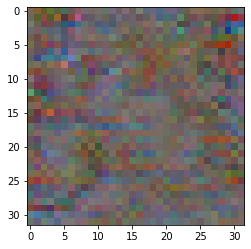

In [239]:
plt.imshow(np.squeeze(symmetric_sample_2))

# Test concept dirft

In [240]:
from scipy.ndimage import rotate
import pandas as pd
from scipy.stats import entropy

In [241]:
cifar100 = tf.keras.datasets.cifar100.load_data()

In [242]:
(x_train_100, y_train_100), (x_test_100, y_test_100) = cifar100
print(x_train_100.shape, x_test_100.shape)
print(y_train_100.shape, y_test_100.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [243]:
x_train_100 = x_train_100.astype('float32')
x_test_100 = x_test_100.astype('float32')
x_train_100 /= 255
x_test_100 /= 255

In [244]:
accuracy_score(np.argmax(model_cifar.predict(x_test), axis=1), np.argmax(y_test, axis=1))

0.764

In [245]:
accuracy_score(np.argmax(model_cifar.predict(x_test_100), axis=1), y_test_100)

0.0101

### contamination cifar100

In [246]:
y_test = np.argmax(y_test, axis=1)

In [247]:
y_test_100 = y_test_100.flatten()

In [248]:
x_test_100.shape

(10000, 32, 32, 3)

In [256]:
mean_test = []
std_test = []
accs_test = []
for i in range(0, len(x_test_100), 500):
    rnd_idxs  = np.random.choice(range(len(x_test_100)), i)
    
    x_cont = x_test_100[rnd_idxs]
    y_cont = y_test_100[rnd_idxs]
    
    #print(len(rnd_idxs), y_test.shape, y_cont.shape)
    print('Number of contaminations: {} '.format(i))
    x_test_cont = np.concatenate((x_test, x_cont), axis=0)
    y_test_cont = np.concatenate((y_test, y_cont), axis=0)
    vae_outs_test = vae.vae.predict(x_test_cont.reshape(x_test_cont.shape[0], 32, 32, 3))
    symm_samples_test = vae_outs_test[0]
    orig_preds_test = vae_outs_test[1]
    trans_preds_test = vae_outs_test[2]
    
    kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
    mean_test.append(kl_test.mean())
    std_test.append(kl_test.std())
    preds_test = np.argmax(orig_preds_test, axis=1)
    accs_test.append(accuracy_score(preds_test, y_test_cont))

Number of contaminations: 0 
Number of contaminations: 500 
Number of contaminations: 1000 
Number of contaminations: 1500 
Number of contaminations: 2000 
Number of contaminations: 2500 
Number of contaminations: 3000 
Number of contaminations: 3500 
Number of contaminations: 4000 
Number of contaminations: 4500 
Number of contaminations: 5000 
Number of contaminations: 5500 
Number of contaminations: 6000 
Number of contaminations: 6500 
Number of contaminations: 7000 
Number of contaminations: 7500 
Number of contaminations: 8000 
Number of contaminations: 8500 
Number of contaminations: 9000 
Number of contaminations: 9500 


In [257]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4801b1a20>,
      dtype=object)

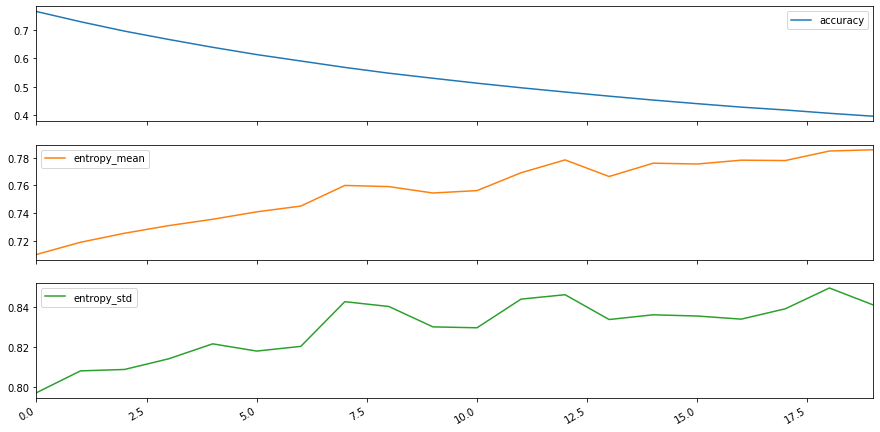

In [258]:
df.plot(logy = False, subplots=True, figsize = (15, 8))

### Rotations

In [252]:
mean_test = []
std_test = []
accs_test = []
for i in range(45):
    
    print('Rotating images by {} degree'.format(i))
    x_test_rot = rotate(x_test, i, axes=(1, 2), reshape=False)
    
    vae_outs_test = vae.vae.predict(x_test_rot.reshape(x_test_rot.shape[0], 32, 32, 3))
    symm_samples_test = vae_outs_test[0]
    orig_preds_test = vae_outs_test[1]
    trans_preds_test = vae_outs_test[2]
    
    kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
    mean_test.append(kl_test.mean())
    std_test.append(kl_test.std())
    preds_test = np.argmax(orig_preds_test, axis=1)
    accs_test.append(accuracy_score(preds_test, y_test))

Rotating images by 0 degree
Rotating images by 1 degree
Rotating images by 2 degree
Rotating images by 3 degree
Rotating images by 4 degree
Rotating images by 5 degree
Rotating images by 6 degree
Rotating images by 7 degree
Rotating images by 8 degree
Rotating images by 9 degree
Rotating images by 10 degree
Rotating images by 11 degree
Rotating images by 12 degree
Rotating images by 13 degree
Rotating images by 14 degree
Rotating images by 15 degree
Rotating images by 16 degree
Rotating images by 17 degree
Rotating images by 18 degree
Rotating images by 19 degree
Rotating images by 20 degree
Rotating images by 21 degree
Rotating images by 22 degree
Rotating images by 23 degree
Rotating images by 24 degree
Rotating images by 25 degree
Rotating images by 26 degree
Rotating images by 27 degree
Rotating images by 28 degree
Rotating images by 29 degree
Rotating images by 30 degree
Rotating images by 31 degree
Rotating images by 32 degree
Rotating images by 33 degree
Rotating images by 34 de

In [254]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4802840f0>,
      dtype=object)

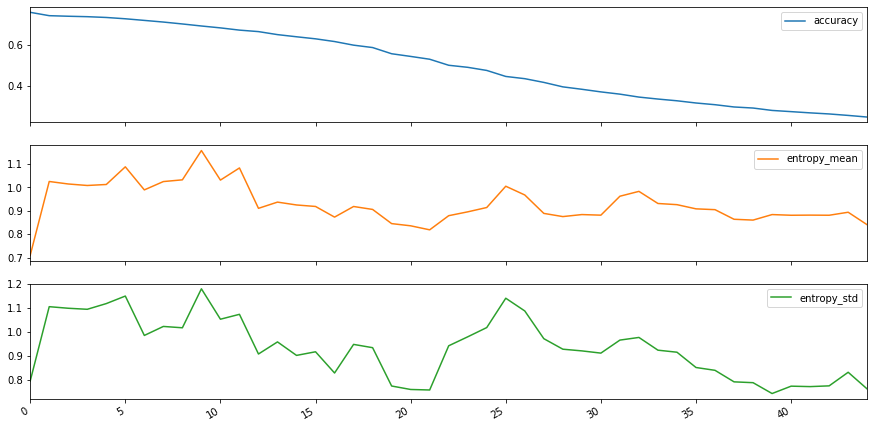

In [255]:
df.plot(logy = False, subplots=True, figsize = (15, 8))

### random features permutation

In [259]:
x_test.shape

(10000, 32, 32, 3)

In [268]:
nb_features = 32 * 32 

In [269]:
nb_features

1024

In [313]:
mean_test = []
std_test = []
accs_test = []
for nb_perm in range(20):
    i = np.random.choice(range(32), nb_perm)
    i_prime = np.random.choice(range(32), nb_perm)
    j = np.random.choice(range(32), nb_perm)
    j_prime = np.random.choice(range(32), nb_perm)
    if nb_perm == 0:
        k = np.random.choice(range(3), 0)
        k_prime = np.random.choice(range(3), 0)
    else:
        k = np.random.choice(range(3), 1)
        k_prime = np.random.choice(range(3), 1)
    
    x_perm = x_test.copy()
    
    x_perm[:, i, :, :] = x_test[:, i_prime, :, :]
    x_perm[:, :, j, :] = x_test[:, :, j_prime, :]
    x_perm[:, :, :, k] = x_test[:, :, :, k_prime]
    
    print('Nb of permutations: {}'.format(nb_perm))
    vae_outs_test = vae.vae.predict(x_perm.reshape(x_perm.shape[0], 32, 32, 3))
    symm_samples_test = vae_outs_test[0]
    orig_preds_test = vae_outs_test[1]
    trans_preds_test = vae_outs_test[2]
    
    kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
    mean_test.append(kl_test.mean())
    std_test.append(kl_test.std())
    preds_test = np.argmax(orig_preds_test, axis=1)
    accs_test.append(accuracy_score(preds_test, y_test))

Nb of permutations: 0
Nb of permutations: 1
Nb of permutations: 2
Nb of permutations: 3
Nb of permutations: 4
Nb of permutations: 5
Nb of permutations: 6
Nb of permutations: 7
Nb of permutations: 8
Nb of permutations: 9
Nb of permutations: 10
Nb of permutations: 11
Nb of permutations: 12
Nb of permutations: 13
Nb of permutations: 14
Nb of permutations: 15
Nb of permutations: 16
Nb of permutations: 17
Nb of permutations: 18
Nb of permutations: 19


In [314]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4797d1b00>,
      dtype=object)

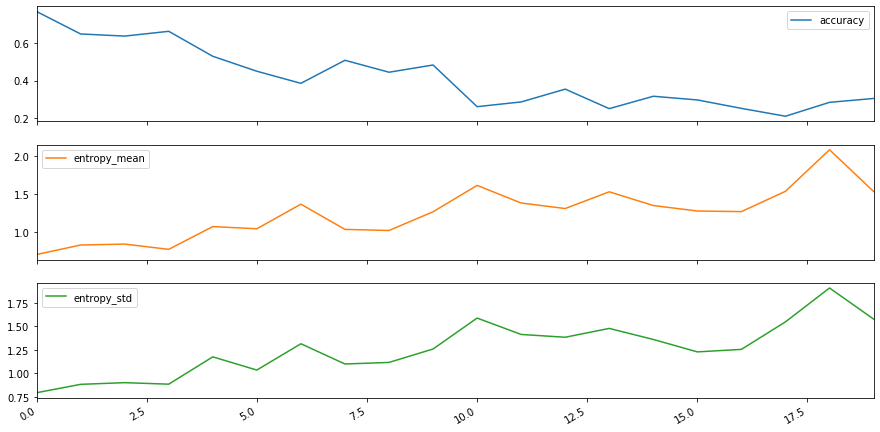

In [315]:
df.plot(logy = False, subplots=True, figsize = (15, 8))

# ACDC

In [273]:
n

1987

In [301]:
i = np.random.choice(range(32), 0)
i_prime = np.random.choice(range(32), 0)
j = np.random.choice(range(32), 0)
j_prime = np.random.choice(range(32), 0)
k = np.random.choice(range(3), 0)
k_prime = np.random.choice(range(3), 0)

In [302]:
x_perm = x_test.copy()

In [303]:
(x_test == x_perm).all()

True

In [304]:
x_perm[:, i, :, :] = x_test[:, i_prime, :, :]
x_perm[:, :, j, :] = x_test[:, :, j_prime, :]
x_perm[:, :, :, k] = x_test[:, :, :, k_prime]

In [305]:
(x_test == x_perm).all()

True

In [290]:
j

array([ 5,  8,  8, 15, 13])

In [291]:
k

array([0])

In [295]:
x_test[:, i, :, :].shape

(10000, 5, 32, 3)

In [281]:
k = 32 % (32 * 32)

In [282]:
k

32

In [277]:
j = (2009 - (k * 32 * 32)) % 32

In [278]:
j

25

In [ ]:
i = (32 * 32) 